In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from combat.pycombat import pycombat
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE
import joblib
import shap
import lime
import re
shap.initjs()

os.chdir("../../Dataset/Merged")

dataset = pd.read_csv('MergedDataset-136411.csv', index_col=0)

sampleID = dataset['SampleID']
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
indicator = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

dataset = pycombat(dataset.transpose(), datasetID).transpose()

dataset.insert(0, 'SampleID', sampleID)
dataset.insert(1, 'Label', indicator)

def getPatientID(sampleID):
    return sampleID.split('-')[0] + '-' + sampleID.split('-')[1].split('_', 1)[1]

dataset.insert(1, 'PatientID', dataset['SampleID'].apply(getPatientID))
gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state = 42)
split = splitter.split(train, groups=train['PatientID'])
train_inds, val_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
val = dataset.iloc[val_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("Dataset di validation:")
print(val.shape)
print("I malati sono: ", sum(val['Label'] == 1))
print("I sani sono: ", sum(val['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])

y_val = val['Label']
x_val = val.drop(columns=['SampleID', 'Label', 'PatientID'])

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])

Found 6 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data
Dataset di train:
(1060, 12094)
I malati sono:  543
I sani sono:  517
Dataset di validation:
(280, 12094)
I malati sono:  155
I sani sono:  125

Dataset di test:
(464, 12094)
I malati sono:  177
I sani sono:  287


In [11]:
ensemble = joblib.load('../../Modelli/DatasetReduced/ensembleSoft.pkl')
shap_values = joblib.load('../../ShapValues/DatasetReduced/ensemble_expl.pkl')
shap_importance = np.abs(shap_values).mean(0)

In [12]:
shap_importance = joblib.load("../../ShapValues/DatasetReduced/ensemble_summary.pkl")

shapDict = dict(zip(x_train.columns, shap_importance))
sorted_dict = dict(sorted(shapDict.items(), key=lambda x: x[1], reverse=True))
print(sorted_dict)

{'DDX3Y': 0.07263586260033689, 'USP9Y': 0.03829022499438604, 'GIT2': 0.025340911749893173, 'PABPC1': 0.02047158262589636, 'RPS4Y1': 0.014321685284934086, 'C4BPA': 0.013950632880016595, 'HLA-DRB5': 0.01388628935608371, 'HLA-DRB1': 0.012453916032550694, 'UBR4': 0.007427471237048653, 'CRIPTO': 0.006753109590780957, 'S100B': 0.0033429032017921684, 'CXCL2': 0.002868668525055161, 'PFDN5': 0.002824643335775785, 'IL22': 0.002724005199144743, 'ZFY': 0.0020604310467367687, 'KCNE2': 0.0017018336555716723, 'BTNL3': 0.0016125518720618516, 'EEF1A1': 0.0009595051722823544, 'GABRB2': 0.0009151305813722814, 'HNRNPA1': 0.0007153106544390025, 'LALBA': 0.0006538436832208877, 'AREG': 0.0006379630660561882, 'RPL13A': 0.000607168140272426, 'RPS3': 0.0004687726889208205, 'USP25': 0.0004517625824625651, 'RPS29': 0.0003709798642913243, 'TRMT5': 0.0003487701833078273, 'SEMA4D': 0.00033877878572263027, 'VDAC3': 0.0003294390861049531, 'RPL28': 0.00024573501304743744, 'NIPSNAP3B': 0.00023806296584526985, 'FRG1': 0.

In [17]:
current = joblib.load("../../ShapValues/DatasetReduced/ensembleSoft_featureImportance.pkl")
sort = list(current.values())
sort.sort(reverse=True)
print(sort[0])

0.9805194805194806


In [18]:
print(len(current.keys()))

4113


In [21]:
def featureSelection(model, x_train, y_train, x_val, y_val, shapImportance, featureNames, current):
    shapDict = dict(zip(featureNames, shapImportance))
    sorted_dict = dict(sorted(shapDict.items(), key=lambda x: x[1], reverse=True))
    result = current
    count = 0
    currentList = list(current.values())
    currentList.sort(reverse=True)
    best = currentList[0]
    try:
        for i in range(len(list(current.values())), len(sorted_dict)):
            featureSelected = list(sorted_dict.keys())[:i]
            x_train_splitted = x_train[featureSelected]
            x_val_splitted = x_val[featureSelected]
            model.fit(x_train_splitted, y_train)
            y_pred = model.predict(x_val_splitted)
            score = f1_score(y_val, y_pred)
            result[tuple(featureSelected)] = score


            print(i)
            print(i, best, score, score-best)

            if i > 4000 and  score - best <= 0:
                count = count + 1

                if count == 100:
                    break
            else: count=0

            if score > best: best = score
    except KeyboardInterrupt:
        print(best)
    return result

result = featureSelection(ensemble, x_train, y_train, x_val, y_val, shap_importance, x_train.columns, current)

0.9805194805194806


In [22]:
featureImportance = joblib.load("../../ShapValues/DatasetReduced/ensembleSoft_featureImportance.pkl")

In [ ]:
sortedFeature = dict(sorted(featureImportance.items(), key=lambda x: x[1], reverse=True))

def prettyPrint(sortedFeature):
    print("Score\tnumFeature\tfeature")
    for i in sortedFeature.keys():
        print(str(sortedFeature[i])+"\t"+str(len(list(i)))+"\t", i)


prettyPrint(sortedFeature)

In [35]:
keys_with_value = [key for key, value in featureImportance.items() if value > 0.98039]
sorted_keys = sorted(keys_with_value, key=lambda x: len(x), reverse=False)
print(len(sorted_keys[0]))

1889


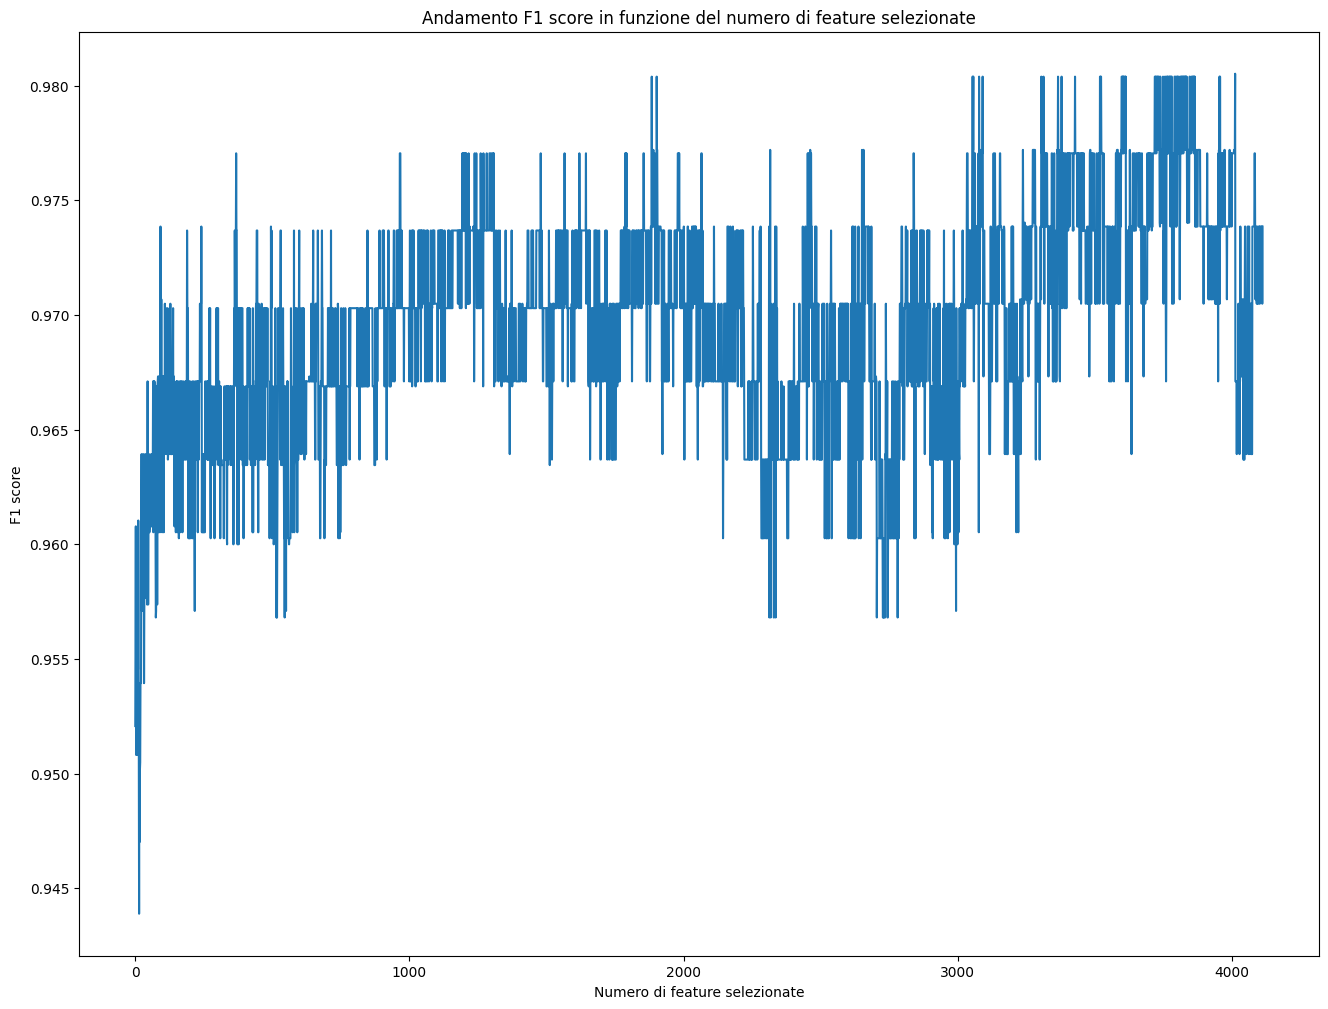

In [24]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.plot(list(featureImportance.values()))
ax.set_title("Andamento F1 score in funzione del numero di feature selezionate")
ax.set_xlabel("Numero di feature selezionate")
ax.set_ylabel("F1 score")
plt.show()